# CSIS 4260 - Assightment 1
**Name:** Ianna Iaichkina  
**Student ID:** 300234152


In [2]:
# 1 — Storage Benchmark

In [3]:
import pandas as pd
import numpy as np
import os
import time
import shutil


df = pd.read_csv('all_stocks_5yr.csv')
df.head()


,date,open,high,low,close,volume,name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [5]:
df['date'] = pd.to_datetime(df['date'])  # string to date
df = df.sort_values(['name','date'])     # sorting 
df.head()


,date,open,high,low,close,volume,name
71611,2013-02-08,45.07,45.35,45.00,45.08,1824755,A
71612,2013-02-11,45.17,45.18,44.45,44.60,2915405,A
71613,2013-02-12,44.81,44.95,44.50,44.62,2373731,A
71614,2013-02-13,44.81,45.24,44.68,44.75,2052338,A
71615,2013-02-14,44.72,44.78,44.36,44.58,3826245,A


In [6]:
os.makedirs("results", exist_ok=True)


In [7]:

folder = "results"

if os.path.exists(folder):
    shutil.rmtree(folder)

os.makedirs(folder)
print("Folder results cleaned ✅")


Folder results cleaned ✅


In [8]:
#  Function of 1x benchmark: write + read + size

def benchmark(write_func, read_func, filename):
    start = time.time()
    write_func()
    write_time = time.time() - start

    size_mb = os.path.getsize(filename) / (1024 * 1024)

    start = time.time()
    read_func()
    read_time = time.time() - start

    return write_time, read_time, size_mb


In [9]:
# function run benchmarks (1x/10x/100x): CSV + Parquet (snappy, zstd)
def run_benchmarks(data, label, folder="results"):
    rows = []

    # CSV
    csv_file = f"{folder}/stocks_{label}.csv"
    wt, rt, sz = benchmark(
        write_func=lambda: data.to_csv(csv_file, index=False),
        read_func=lambda: pd.read_csv(csv_file),
        filename=csv_file
    )
    rows.append([label, "CSV", wt, rt, sz])

    # Parquet snappy
    
    pq_snappy = f"{folder}/stocks_{label}_snappy.parquet"
    wt, rt, sz = benchmark(
        write_func=lambda: data.to_parquet(pq_snappy, compression="snappy"),
        read_func=lambda: pd.read_parquet(pq_snappy),
        filename=pq_snappy
    )
    rows.append([label, "Parquet (snappy)", wt, rt, sz])

    # Parquet zstd
    
    pq_zstd = f"{folder}/stocks_{label}_zstd.parquet"
    wt, rt, sz = benchmark(
        write_func=lambda: data.to_parquet(pq_zstd, compression="zstd"),
        read_func=lambda: pd.read_parquet(pq_zstd),
        filename=pq_zstd
    )
    rows.append([label, "Parquet (zstd)", wt, rt, sz])

    return pd.DataFrame(rows, columns=["Scale", "Format", "Write Time (s)", "Read Time (s)", "File Size (MB)"])


In [10]:
# runing 1x
results_1x = run_benchmarks(df, "1x")
results_1x


,Scale,Format,Write Time (s),Read Time (s),File Size (MB)
0,1x,CSV,2.764163,0.341988,28.210210
1,1x,Parquet (snappy),0.236191,0.108960,12.760529
2,1x,Parquet (zstd),0.182032,0.030562,8.941095


In [11]:
# Creating 10x и 100x
df_10x = pd.concat([df]*10, ignore_index=True)
df_100x = pd.concat([df]*100, ignore_index=True)

df_10x.shape, df_100x.shape


((6190400, 7), (61904000, 7))

In [12]:
# runing 10x и 100x
results_10x = run_benchmarks(df_10x, "10x")
results_100x = run_benchmarks(df_100x, "100x")

results_10x, results_100x


(  Scale            Format  Write Time (s)  Read Time (s)  File Size (MB)
 0   10x               CSV       23.080038       3.014353      282.101781
 1   10x  Parquet (snappy)        1.302578       0.360750       95.236692
 2   10x    Parquet (zstd)        1.473486       0.256702       75.376322,
   Scale            Format  Write Time (s)  Read Time (s)  File Size (MB)
 0  100x               CSV      231.049655      41.943746     2821.017491
 1  100x  Parquet (snappy)       13.085451       5.945444      951.902069
 2  100x    Parquet (zstd)       16.539619       7.270180      751.553837)

In [13]:
results_all = pd.concat([results_1x, results_10x, results_100x], ignore_index=True)
results_all


,Scale,Format,Write Time (s),Read Time (s),File Size (MB)
0,1x,CSV,2.764163,0.341988,28.210210
1,1x,Parquet (snappy),0.236191,0.108960,12.760529
2,1x,Parquet (zstd),0.182032,0.030562,8.941095
3,10x,CSV,23.080038,3.014353,282.101781
4,10x,Parquet (snappy),1.302578,0.360750,95.236692
5,10x,Parquet (zstd),1.473486,0.256702,75.376322
6,100x,CSV,231.049655,41.943746,2821.017491
7,100x,Parquet (snappy),13.085451,5.945444,951.902069
8,100x,Parquet (zstd),16.539619,7.270180,751.553837


In [14]:
# Part 2 – Data Processing and Machine Learning

In [15]:
# choosing company
df_stock = df[df["name"] == "AAPL"].copy()
df_stock = df_stock.sort_values("date")


In [16]:
# SMA
df_stock["SMA_14"] = df_stock["close"].rolling(window=14).mean()


In [17]:
# RSI
delta = df_stock["close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df_stock["RSI_14"] = 100 - (100 / (1 + rs))


In [18]:
df_stock = df_stock.dropna().reset_index(drop=True)


In [19]:
# target- next day
df_stock["target"] = df_stock["close"].shift(-1)
df_stock = df_stock.dropna().reset_index(drop=True)


In [20]:
features = ["close", "volume", "SMA_14", "RSI_14"]
X = df_stock[features]
y = df_stock["target"]


In [21]:
split = int(len(df_stock) * 0.8)

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]


In [22]:
# Model 1: Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr = r2_score(y_test, pred_lr)

mae_lr, rmse_lr, r2_lr


(1.3127959298763598, 1.8935102276087523, 0.9754528112386935)

In [23]:
# Model 2: Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)

mae_rf, rmse_rf, r2_rf


(25.79106124497991, 28.516148245774783, -4.567345571487038)

In [24]:
# Model of comparison tables

import pandas as pd

model_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R2": [r2_lr, r2_rf]
})

model_results


,Model,MAE,RMSE,R2
0,Linear Regression,1.312796,1.893510,0.975453
1,Random Forest,25.791061,28.516148,-4.567346


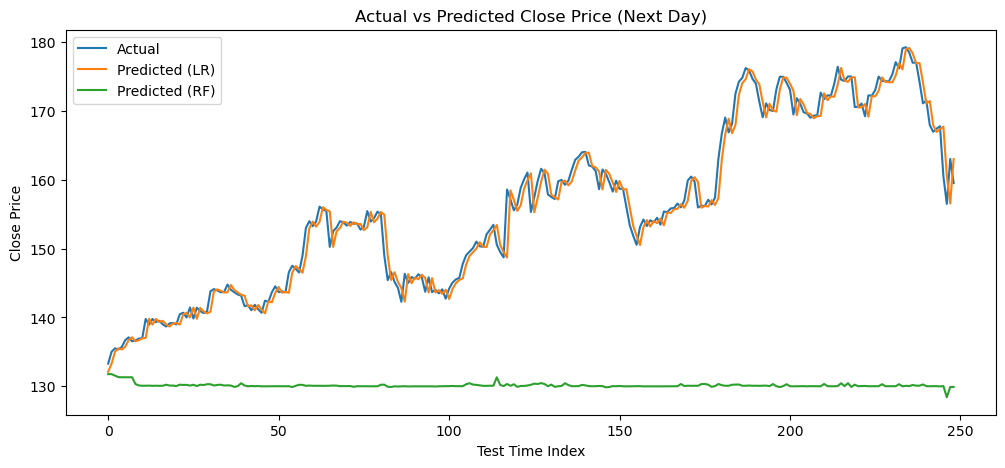

In [25]:
# Prediction vs Actual

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual")
plt.plot(pred_lr, label="Predicted (LR)")
plt.plot(pred_rf, label="Predicted (RF)")
plt.title("Actual vs Predicted Close Price (Next Day)")
plt.xlabel("Test Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [26]:
# Pandas vs Polars (Performance Comparison)

!pip install polars

import polars as pl

import time
import numpy as np

def pandas_pipeline(df, ticker="AAPL"):
    d = df[df["name"] == ticker].copy()
    d = d.sort_values("date")
    
    d["SMA_14"] = d["close"].rolling(14).mean()

    delta = d["close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    d["RSI_14"] = 100 - (100 / (1 + rs))

    d = d.dropna()
    d["target"] = d["close"].shift(-1)
    d = d.dropna()
    return d

start = time.time()
out_pd = pandas_pipeline(df, "AAPL")
pandas_time = time.time() - start

pandas_time, out_pd.shape



(0.04020214080810547, (1244, 10))

In [27]:
def polars_pipeline(path_csv, ticker="AAPL"):
    d = (
        pl.read_csv(path_csv, try_parse_dates=True)
        .filter(pl.col("name") == ticker)
        .sort("date")
    )

    d = d.with_columns([
        pl.col("close").rolling_mean(window_size=14).alias("SMA_14"),
        pl.col("close").diff().alias("delta")
    ])

    d = d.with_columns([
        pl.when(pl.col("delta") > 0).then(pl.col("delta")).otherwise(0).alias("gain"),
        pl.when(pl.col("delta") < 0).then(-pl.col("delta")).otherwise(0).alias("loss")
    ])

    d = d.with_columns([
        pl.col("gain").rolling_mean(14).alias("avg_gain"),
        pl.col("loss").rolling_mean(14).alias("avg_loss")
    ])

    d = d.with_columns([
        (100 - (100 / (1 + (pl.col("avg_gain") / pl.col("avg_loss"))))).alias("RSI_14")
    ])

    d = d.drop_nulls()
    d = d.with_columns([
        pl.col("close").shift(-1).alias("target")
    ]).drop_nulls()

    return d

start = time.time()
out_pl = polars_pipeline("all_stocks_5yr.csv", "AAPL")
polars_time = time.time() - start

polars_time, out_pl.shape


(0.2152550220489502, (1245, 15))

In [28]:
perf = pd.DataFrame({
    "Library": ["Pandas", "Polars"],
    "Time (s)": [pandas_time, polars_time],
    "Rows Output": [out_pd.shape[0], out_pl.shape[0]]
})
perf


,Library,Time (s),Rows Output
0,Pandas,0.040202,1244
1,Polars,0.215255,1245


In [29]:
!pip install streamlit
